In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay, auc, accuracy_score, classification_report
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import xgboost as xgb

**<span style="font-size:larger;">Load Data</span>**

In [2]:
# load PRJEB7774 data
relab_abundance_data_7774 = pd.read_feather('C:/Users/odesa/Desktop/CRCFinal/PRJEB7774/relab_PRJEB7774_pooled_abun.feather') # In relative abundance, UNMAPPED included, pooled. (Normalized to read depth)
CLR_abundance_data_7774 = pd.read_feather('C:/Users/odesa/Desktop/CRCFinal/PRJEB7774/CLR_PRJEB7774_pooled_abun.feather') # In CLR, UNMAPPED removed, pooled. (not normalized to read depth)
metadata_7774 = pd.read_feather('C:/Users/odesa/Desktop/CRCFinal/PRJEB7774/PRJEB7774_metadata.feather') # metadata for PRJEB7774

In [ ]:
display(relab_abundance_data_7774)
display(CLR_abundance_data_7774)
display(metadata_7774)

**<span style="font-size:larger;">Clean Data for Training</span>**

In [3]:
# rows_with_na = relab_abundance_data_7774[relab_abundance_data_7774.isna().any(axis=1)]
# print(rows_with_na)

rows_with_na = CLR_abundance_data_7774[CLR_abundance_data_7774.isna().any(axis=1)]
print(rows_with_na)

# Sample ID ERR688638 has NAs in the CLR abundance data, drop from all
relab_abundance_data_7774 = relab_abundance_data_7774[relab_abundance_data_7774['sample_id'] != 'ERR688638']
CLR_abundance_data_7774 = CLR_abundance_data_7774[CLR_abundance_data_7774['sample_id'] != 'ERR688638']
metadata_7774 = metadata_7774[metadata_7774['run_accession'] != 'ERR688638']

     Amidase  DD-carboxypeptidase  DD-endopeptidase  DL-endopeptidase  \
132      inf                  inf               inf               inf   

     Glucosaminidase  LD-carboxypeptidase  LD-endopeptidase  Muramidase  \
132              inf                  inf               NaN         inf   

     sample_id  
132  ERR688638  


In [ ]:
metadata_7774.rename(columns={'run_accession': 'sample_id'}, inplace=True)
display(metadata_7774)


metadata_7774 = metadata_7774[metadata_7774['sample_id'].isin(relab_abundance_data_7774['sample_id'])]
display(metadata_7774)

In [5]:
relab_abundance_data_7774.set_index('sample_id', inplace=True)
CLR_abundance_data_7774.set_index('sample_id', inplace=True)
metadata_7774.set_index('sample_id', inplace=True)

In [ ]:
metadata_7774['sample_title'] = metadata_7774['sample_title'].map({'Control': 0, 'Adenoma': 0, 'Carcinoma': 1})
display(metadata_7774)

In [7]:
# Ensure consistent ordering of rows
metadata_774 = metadata_7774.reindex(relab_abundance_data_7774.index)
CLR_abundance_data_7774 = CLR_abundance_data_7774.reindex(relab_abundance_data_7774.index)

# Drop DACS and UC118 columnsfrom relab abundance data
relab_abundance_data_7774.drop(columns=['Diadenylate', 'UC118'], inplace=True)

display(relab_abundance_data_7774)

,Amidase,DD-carboxypeptidase,DD-endopeptidase,DL-endopeptidase,Glucosaminidase,LD-carboxypeptidase,LD-endopeptidase,Muramidase,UNMAPPED
sample_id,,,,,,,,,
ERR688505,0.001340,0.001220,0.000204,0.000597,0.000298,0.000161,0.000006,0.001571,0.994337
ERR688506,0.001213,0.001103,0.000086,0.000448,0.000246,0.000144,0.000015,0.001173,0.995306
ERR688507,0.001110,0.001140,0.000164,0.000475,0.000302,0.000120,0.000023,0.001114,0.995279
ERR688508,0.001146,0.000882,0.000095,0.000330,0.000380,0.000137,0.000008,0.000856,0.995857
ERR688509,0.001151,0.001430,0.000098,0.000478,0.000215,0.000115,0.000005,0.001188,0.995031
...,...,...,...,...,...,...,...,...,...
ERR710428,0.000954,0.000619,0.000251,0.000372,0.000300,0.000113,0.000012,0.001155,0.995962
ERR710429,0.000895,0.000954,0.000154,0.000380,0.000262,0.000125,0.000021,0.000974,0.995975
ERR710430,0.001578,0.001207,0.000059,0.000277,0.000272,0.000135,0.000019,0.001057,0.995107


In [17]:
display(metadata_774)

,sample_title
sample_id,
ERR688505,1
ERR688506,0
ERR688507,0
ERR688508,0
ERR688509,0
...,...
ERR710428,0
ERR710429,0
ERR710430,0


In [13]:
# Split the data into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(relab_abundance_data_7774, metadata_774['sample_title'], test_size=0.2, 
                                                    random_state=42)

# Split the data into training, validation, and test sets
X_train_CLR, X_test_CLR, y_train_CLR, y_test_CLR = train_test_split(CLR_abundance_data_7774, metadata_774['sample_title'], test_size=0.2, 
                                                    random_state=42)

# Print the shapes of the resulting dataframes
print("Training set shape:", X_train.shape, y_train.shape)
#print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)

# Print the shapes of the resulting dataframes
print("Training set shape:", X_train_CLR.shape, y_train_CLR.shape)
#print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test_CLR.shape, y_test_CLR.shape)

# display(X_train)
# display(X_train_CLR)


Training set shape: (123, 9) (123,)
Test set shape: (31, 9) (31,)
Training set shape: (123, 8) (123,)
Test set shape: (31, 8) (31,)


In [14]:
rf_relab = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=rf_relab, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=2, scoring='accuracy')

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_

print(f"Best parameters: {best_params}")

# Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 50}


In [18]:
# Using the best parameters from grid search
best_params = {
    'max_depth': None, 
    'max_features': 'sqrt', 
    'min_samples_leaf': 4, 
    'min_samples_split': 2, 
    'n_estimators': 50,
    'random_state': 42 
}

# Create and train the model
rf_model = RandomForestClassifier(**best_params)
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Predict the probabilities for the test set
y_prob = rf_model.predict_proba(X_test)[:, 1]

In [19]:
# # Calculate multivariate metrics
# accuracy = accuracy_score(y_test, y_pred)
# f1_micro = f1_score(y_test, y_pred, average='micro')
# f1_macro = f1_score(y_test, y_pred, average='macro')
# f1_weighted = f1_score(y_test, y_pred, average='weighted')
# roc_auc = roc_auc_score(y_test, y_prob, multi_class='ovo')

# print(f"Accuracy: {accuracy}")
# print(f"F1 Micro: {f1_micro}, F1 Macro: {f1_macro}, F1 Weighted: {f1_weighted}")
# print(f"ROC AUC: {roc_auc}")

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"ROC AUC: {roc_auc}")

Accuracy: 0.6451612903225806
F1 Score: 0.26666666666666666
ROC AUC: 0.5772727272727273


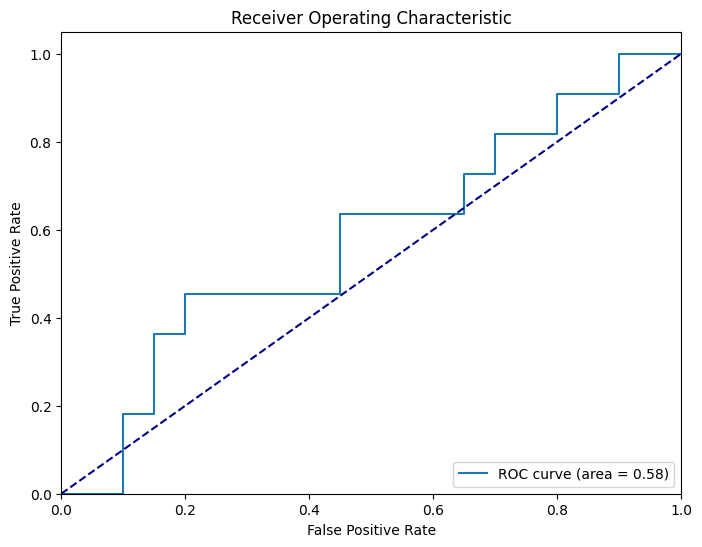

In [20]:
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

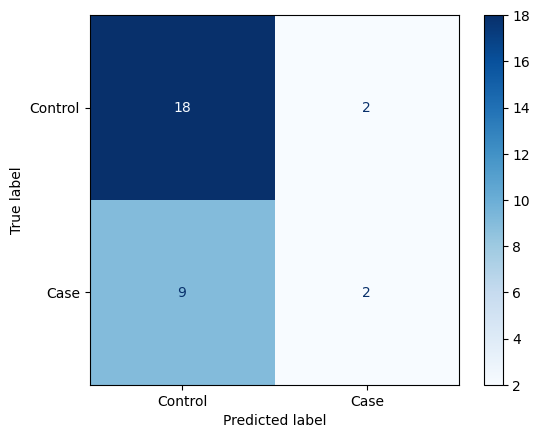

In [21]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

labels = ['Control', 'Case']


# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.savefig('confusion_matrix.png', dpi=300)

In [ ]:
rf_clr = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=rf_clr, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=2, scoring='accuracy')

grid_search.fit(X_train_CLR, y_train_CLR)

best_params = grid_search.best_params_

print(f"Best parameters: {best_params}")

In [ ]:
# Using the best parameters from grid search
best_params = {
    'max_depth': None, 
    'max_features': 'sqrt', 
    'min_samples_leaf': 2, 
    'min_samples_split': 2, 
    'n_estimators': 100,
    'random_state': 42 
}

# Create and train the model
rf_model = RandomForestClassifier(**best_params)
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Predict the probabilities for the test set
y_prob = rf_model.predict_proba(X_test)

In [ ]:
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
f1_micro = f1_score(y_test, y_pred, average='micro')
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')
roc_auc = roc_auc_score(y_test, y_prob, multi_class='ovo')

print(f"Accuracy: {accuracy}")
print(f"F1 Micro: {f1_micro}, F1 Macro: {f1_macro}, F1 Weighted: {f1_weighted}")
print(f"ROC AUC: {roc_auc}")

**<span style="font-size:larger;">PCA Analysis</span>**


In [19]:
features = abundance_data_7774.drop('sample_title', axis=1)
labels = abundance_data_7774['sample_title']

In [20]:
# Apply PCA
pca = PCA(n_components=2)
abundance_data_pca = pca.fit_transform(features)

In [21]:
principalDf = pd.DataFrame(data=abundance_data_pca, columns=['PC1', 'PC2'])
principalDf['Label'] = labels.values

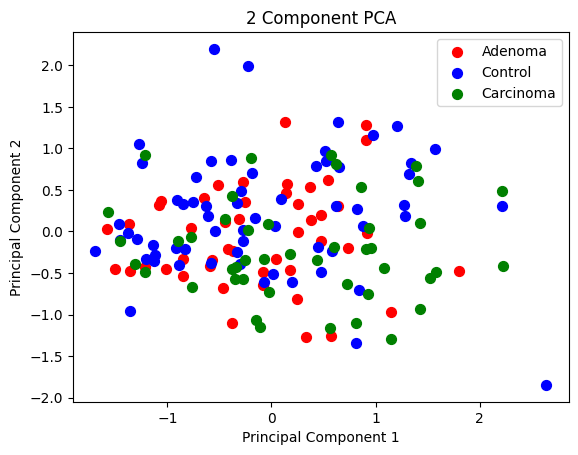

In [23]:
# Plot the principal components, colored by label
fig, ax = plt.subplots()

colors = {'Adenoma': 'red', 'Control': 'blue', 'Carcinoma': 'green'}

# Plot each label as a different color
for label, color in colors.items():
    indicesToKeep = principalDf['Label'] == label
    ax.scatter(principalDf.loc[indicesToKeep, 'PC1'],
               principalDf.loc[indicesToKeep, 'PC2'],
               c=color,
               s=50,
               label=label)  # Add label for legend

# Label axes
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_title('2 Component PCA')

# Show legend
ax.legend()

# Show plot
plt.show()